# Train and evaluate a PC

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

Set the random seeds.

In [2]:
random.seed(42)
np.random.seed(42)

## Load MNIST Dataset

Load the training and test splits of MNIST, and preprocess them by flattening the tensor images.

In [3]:
from torchvision import transforms, datasets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (255 * x.view(-1)).long())
])
data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)
num_variables = data_train[0][0].shape[0]
height, width = 28, 28
print(f"Number of variables: {num_variables}")

Number of variables: 784


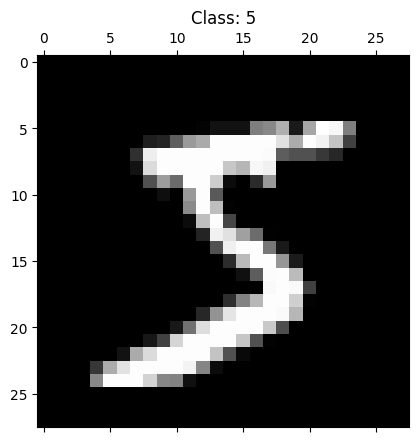

In [4]:
plt.matshow(data_train[0][0].reshape(28, 28), cmap='gray')
plt.title(f"Class: {data_train[0][1]}")
plt.show()

## Instantiating a Circuit structure Template: the Region Graph

Initialize a _Quad Graph_ region graph.

In [5]:
from cirkit.templates.region_graph import QuadTree

region_graph = QuadTree(shape=(height, height))

ModuleNotFoundError: No module named 'cirkit'

Others available region graphs are the _Random Binary Tree_ and the _Poon Domingos_, whose imports are showed below.

In [7]:
from cirkit.templates.region_graph import RandomBinaryTree, PoonDomingos

## Constructing the Symbolic Circuit Representation

From the region graph definition above, we now construct the symbolic circuit representation. Note that this circuit representation is _not_ executable, i.e., you cannot do learn it or do inference with it. It will be compiled later, by choosing a backend such as torch.

To do so, we first define the factories that will be used to construct symbolic layers. Note that we choose the parameterization at the symbolic level. That is, we guarantee non-negative parameters by passing them through an exponential function. Moreover, we can choose how to parameterize the categorical distributions used to model the distribution of pixel values in the 0-255 range. In this case, we use a log softmax function. We choose to initialize the weights of the circuit by sampling from a normal distribution.

In [8]:
from cirkit.utils.scope import Scope
from cirkit.symbolic.parameters import LogSoftmaxParameter, SoftmaxParameter, ExpParameter, Parameter, TensorParameter
from cirkit.symbolic.layers import CategoricalLayer, DenseLayer, HadamardLayer, MixingLayer
from cirkit.symbolic.initializers import NormalInitializer

In [9]:
def categorical_layer_factory(
    scope: Scope,
    num_units: int,
    num_channels: int
) -> CategoricalLayer:
    return CategoricalLayer(
        scope, num_units, num_channels, num_categories=256,
        logits_factory=lambda shape: Parameter.from_unary(
            LogSoftmaxParameter(shape),
            TensorParameter(*shape, initializer=NormalInitializer(0.0, 1e-2))
        )
    )

def hadamard_layer_factory(
    scope: Scope, num_input_units: int, arity: int
) -> HadamardLayer:
    return HadamardLayer(scope, num_input_units, arity)

def dense_layer_factory(
    scope: Scope,
    num_input_units: int,
    num_output_units: int
) -> DenseLayer:
    return DenseLayer(
        scope, num_input_units, num_output_units,
        weight_factory=lambda shape: Parameter.from_unary(
            SoftmaxParameter(shape),
            TensorParameter(*shape, initializer=NormalInitializer(0.0, 1e-1))
        )
    )


def mixing_layer_factory(
    scope: Scope, num_units: int, arity: int
) -> MixingLayer:
    return MixingLayer(
        scope, num_units, arity,
        weight_factory=lambda shape: Parameter.from_unary(
            SoftmaxParameter(shape),
            TensorParameter(*shape, initializer=NormalInitializer(0.0, 1e-1))
        )
    )

Then, we call a function to construct the symbolic circuit from region graph, by specifying the number of units and the factories to build layers.

In [10]:
from cirkit.symbolic.circuit import Circuit
from cirkit.pipeline import PipelineContext

In [11]:
%%time
ctx = PipelineContext(
    backend='torch',   # Choose the torch compilation backend
    fold=True,         # Fold the circuit, this is a backend-specific compilation flag
    semiring='lse-sum', # Use the (R, +, *) semiring, where + is the log-sum-exp and * is the sum
    optimize=False      # Optimize the circuit layers (set this flag to False to disable, which yields slower inference)
)

CPU times: user 66 µs, sys: 46 µs, total: 112 µs
Wall time: 116 µs
CPU times: user 66 µs, sys: 46 µs, total: 112 µs
Wall time: 116 µs


In [12]:
from cirkit.backend.torch.layers.input.binomial import compile_binomial_layer, binomial_layer_factory

ctx.add_layer_compilation_rule(compile_binomial_layer)

In [13]:
symbolic_circuit = Circuit.from_region_graph(
    region_graph,
    num_input_units=8,
    num_sum_units=8,
    input_factory=binomial_layer_factory,
    # input_factory=categorical_layer_factory,
    sum_factory=dense_layer_factory,
    prod_factory=hadamard_layer_factory,
    mixing_factory=mixing_layer_factory
)

We can retrieve some information about the circuit and its structural properties as follows.

In [14]:
print(f'Smooth: {symbolic_circuit.is_smooth}')
print(f'Decomposable: {symbolic_circuit.is_decomposable}')
print(f'Number of variables: {symbolic_circuit.num_variables}')
print(f'Number of channels per variable: {symbolic_circuit.num_channels}')

Smooth: True
Decomposable: True
Number of variables: 784
Number of channels per variable: 1
Smooth: True
Decomposable: True
Number of variables: 784
Number of channels per variable: 1


## Compiling the Symbolic Circuit

We are ready to compile the symbolic circuit constructed above into another one that we can learn and/or do inference. To do so, we have to choose a compilation backend. In this case, we choose torch as a backend.

In [15]:
import torch
device = torch.device('cuda')  # The device to use
torch.manual_seed(42)
if 'cuda' in device.type:
    torch.cuda.manual_seed(42)

We first need to instantiate a circuit pipeline context and specify the backend to be used, as well as optional compilation flags, e.g., whether to fold the circuit or which inference semiring to use. Finally, we use the pipeline context to compile the symbolic circuit.

In [16]:
circuit = ctx.compile(symbolic_circuit)

# Alternatively, one can use the Python _with_ statement to compile circuits inside of it.
#
# from cirkit.pipeline import compile
# with PipelineContext(backend='torch', fold=True, semiring='lse-sum') as ctx:
#    circuit = compile(symbolic_circuit)

Note that the compilation step, comprising the folding optimization, required less than 1 second for a circuit with almost 5000 layers.

In [17]:
print(len(list(symbolic_circuit.layers)))

4947
4947


We observe how the tensorized circuit has much fewer layers, as the great majority has been folded.

In [18]:
print(circuit)

TorchCircuit(
  (_nodes): ModuleList(
    (0): TorchBinomialLayer(
      (probs): TorchParameter(
        (_nodes): ModuleList(
          (0): TorchTensorParameter()
          (1): TorchScaledSigmoidParameter()
        )
      )
    )
    (1): TorchDenseLayer(
      (weight): TorchParameter(
        (_nodes): ModuleList(
          (0): TorchTensorParameter()
          (1): TorchSoftmaxParameter()
        )
      )
    )
    (2): TorchHadamardLayer()
    (3): TorchDenseLayer(
      (weight): TorchParameter(
        (_nodes): ModuleList(
          (0): TorchTensorParameter()
          (1): TorchSoftmaxParameter()
        )
      )
    )
    (4): TorchHadamardLayer()
    (5): TorchDenseLayer(
      (weight): TorchParameter(
        (_nodes): ModuleList(
          (0): TorchTensorParameter()
          (1): TorchSoftmaxParameter()
        )
      )
    )
    (6): TorchMixingLayer(
      (weight): TorchParameter(
        (_nodes): ModuleList(
          (0): TorchTensorParameter()
          (

## Training and Testing

We are now ready to learn the parameters and do inference First, we wrap our data into PyTorch data loaders by specifying the batch size. Then, we initialize any PyTorch optimizer, e.g. SGD with momentum in this case.

In [19]:
from torch import optim
from torch.utils.data import DataLoader
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256, drop_last=True, num_workers=4)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256, num_workers=4)
optimizer = optim.SGD(circuit.parameters(), lr=0.1, momentum=0.95)

### Compiling the Circuit computing the Partition Function

Here, we choose to optimize the parameters by minimizing the negative log-likelihood. However, since the circuit is not already normalized (as we parameterized the sums using an exponential), we need to instantiate a circuit computing the partition function explicitly. That is, we integrate the circuit within the pipeline context as follows.

Note that the context will take care of the parameters being shared between the compiled circuit and its other version, which computes the partition function. Finally, we learn the parameters by minimizing the negative log-likelihood, similarly as any other model in torch.

In [21]:
# Move circuits to device
circuit = circuit.to(device)

In [23]:
num_epochs = 10
step_idx = 0
running_loss = 0.0
for epoch_idx in range(num_epochs):
    for i, (batch, _) in enumerate(train_dataloader):
        batch = batch.to(device).unsqueeze(dim=1)   # Add a channel dimension
        log_output = circuit(batch)                 # Compute the log output of the circuit
        lls = log_output                   # Compute the log-likelihood
        loss = -torch.mean(lls)   # The loss is the negative average log-likelihood
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.detach() * len(batch)
        step_idx += 1
        if step_idx % 100 == 0:
            print(f"Step {step_idx}: Average NLL: {running_loss / (100 * len(batch)):.3f}")
            running_loss = 0.0

Step 100: Average NLL: 1046.997
Step 100: Average NLL: 1046.997
Step 200: Average NLL: 1044.018
Step 200: Average NLL: 1044.018
Step 300: Average NLL: 1035.814
Step 300: Average NLL: 1035.814
Step 400: Average NLL: 1030.439
Step 400: Average NLL: 1030.439
Step 500: Average NLL: 1027.048
Step 500: Average NLL: 1027.048
Step 600: Average NLL: 1025.682
Step 600: Average NLL: 1025.682
Step 700: Average NLL: 1022.492
Step 700: Average NLL: 1022.492
Step 800: Average NLL: 1018.791
Step 800: Average NLL: 1018.791
Step 900: Average NLL: 1017.396
Step 900: Average NLL: 1017.396
Step 1000: Average NLL: 1016.861
Step 1000: Average NLL: 1016.861
Step 1100: Average NLL: 1011.868
Step 1100: Average NLL: 1011.868
Step 1200: Average NLL: 1011.084
Step 1200: Average NLL: 1011.084
Step 1300: Average NLL: 1010.059
Step 1300: Average NLL: 1010.059
Step 1400: Average NLL: 1005.126
Step 1400: Average NLL: 1005.126
Step 1500: Average NLL: 1008.082
Step 1500: Average NLL: 1008.082
Step 1600: Average NLL: 1003

We then evaluate our model on test data by computing the average log-likelihood and bits per dimension.

In [24]:
circuit.eval()

with torch.no_grad():
    test_lls = 0.0
    for batch, _ in test_dataloader:
        batch = batch.to(device).unsqueeze(dim=1)   # Add a channel dimension
        log_output = circuit(batch)                 # Compute the log output of the circuit
        lls = log_output                   # Compute the log-likelihood
        test_lls += lls.sum().item()
    average_ll = test_lls / len(data_test)
    bpd = -average_ll / (num_variables * np.log(2.0))
    print(f"Average test LL: {average_ll:.3f}")
    print(f"Bits per dimension: {bpd}")

Average test LL: -997.951
Bits per dimension: 1.8364020822652174
Average test LL: -997.951
Bits per dimension: 1.8364020822652174


## Sampling from the Circuit

To visualise the generative capabilities of the circuit, we can sample from it and plot the results. Note that the sampling operation returns samples from the leaves *and* samples from the corresponding mixtures.

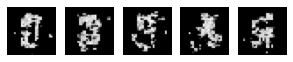

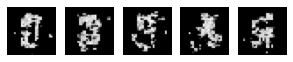

In [26]:
import einops as E

samples = circuit.sample(5)
leaf_samples = samples[0]
mixtures_samples = samples[1]

leaf_samples = leaf_samples[:, 0, :] # Remove the channel dimension
samples = E.rearrange(leaf_samples, "n (h w) -> n h w", h=28, w=28)
samples = samples.cpu().numpy()

plt.figure(figsize=(5, 1))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(samples[i], cmap="gray")
    plt.axis("off")
plt.show()

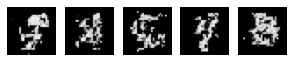

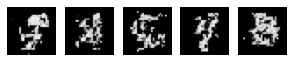

In [27]:
import einops as E

samples = circuit.sample(5)

leaf_samples = samples[0]
mixture_samples = samples[1]

generations = E.rearrange(leaf_samples[:, 0, :], "n (h w) -> n h w", h=28, w=28)
generations = generations.cpu().numpy()

# plot here now
plt.figure(figsize=(5, 1))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(generations[i], cmap="gray")
    plt.axis("off")
plt.show()